In [61]:
from pystac_client import Client
from odc.stac import load, configure_s3_access
from odc.geo import Geometry
from dask.distributed import Client as DaskClient

import numpy as np
import geopandas as gpd

from utils import WGS84GRID30, USGSCATALOG, USGSLANDSAT, http_to_s3_url

In [62]:
# Configure S3 access, which requires AWS credentials for loading USGS Landsat data
configure_s3_access(cloud_defaults=True, requester_pays=True)

client = Client.open(USGSCATALOG)

In [63]:
# Load our extents
gdf = gpd.read_file("aois.geojson")

# 0 is Fiji, 1 is Caribbean and 2 is Belize
geom = Geometry(gdf.geometry[0], crs="epsg:4326")

# This is all the tiles
tiles = WGS84GRID30.tiles_from_geopolygon(geom)

# This is near Suva, Fiji
tile = WGS84GRID30.tile_geobox((119, -13))

# Subset the tile, to load a very small area
tile = tile.crop([250, 250])

In [64]:
type(tile)

odc.geo.geobox.GeoBox

In [51]:
items = client.search(
    collections=[USGSLANDSAT],
    intersects=tile.geographic_extent,
    datetime="2022-11/2024-01",
    query={"landsat:collection_category": {"in": ["T1"]}},
).item_collection()

print(f"Found {len(items)} items")

Found 97 items


In [52]:
data = load(
    items,
    geobox=tile,
    measurements=["red", "nir08", "qa_pixel"],
    chunks={"x": 2048, "y": 2048},
    groupby="solar_day",
    dtype="uint16",
    nodata=0,
    resampling={"qa_pixel": "nearest"},
    patch_url=http_to_s3_url,
)

data = data.rename_vars({"nir08": "nir"})

data

<xarray.Dataset> Size: 20MB
Dimensions:      (latitude: 250, longitude: 250, time: 53)
Coordinates:
  * latitude     (latitude) float64 2kB -18.0 -18.0 -18.0 ... -18.07 -18.07
  * longitude    (longitude) float64 2kB 178.5 178.5 178.5 ... 178.6 178.6 178.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 424B 2022-11-05T22:07:15.885529 ... 20...
Data variables:
    red          (time, latitude, longitude) uint16 7MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 7MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 7MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>

In [53]:
# Create cloud mask, scale values to 0-1 and set nodata to NaN

# Bits 3 and 4 are cloud shadow and cloud, respectively. Bit 0 is nodata
bitflags = 0b00011000

# Bitwise AND to select any pixel that is cloud shadow or cloud or nodata
cloud_mask = (data.qa_pixel & bitflags) != 0
# Note that it might be a good idea to dilate the mask here to catch any pixels that are adjacent to clouds

nodata_mask = data.qa_pixel == 0

# Combined the masks
mask = cloud_mask | nodata_mask

# Mask the original data
masked = data.where(~mask, other=np.nan).drop_vars("qa_pixel")

# Scale the data to 0-1
scaled = (masked.where(masked != 0) * 0.0000275 + -0.2).clip(0, 1)

scaled

<xarray.Dataset> Size: 53MB
Dimensions:      (time: 53, latitude: 250, longitude: 250)
Coordinates:
  * latitude     (latitude) float64 2kB -18.0 -18.0 -18.0 ... -18.07 -18.07
  * longitude    (longitude) float64 2kB 178.5 178.5 178.5 ... 178.6 178.6 178.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 424B 2022-11-05T22:07:15.885529 ... 20...
Data variables:
    red          (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    nir          (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>

In [54]:
# Create the indices

# NDVI
scaled["ndvi"] = (scaled["nir"] - scaled["red"]) / (scaled["nir"] + scaled["red"])

# MSAVI
scaled["msavi"] = 0.5 * (
    (2 * scaled["nir"] + 1) - np.sqrt((2 * scaled["nir"] + 1) ** 2 - 8 * (scaled["nir"] - scaled["red"]))
)

# EVI2
scaled["evi2"] = 2.5 * (scaled["nir"] - scaled["red"]) / (scaled["nir"] + 2.4 * scaled["red"] + 1)

scaled

<xarray.Dataset> Size: 133MB
Dimensions:      (time: 53, latitude: 250, longitude: 250)
Coordinates:
  * latitude     (latitude) float64 2kB -18.0 -18.0 -18.0 ... -18.07 -18.07
  * longitude    (longitude) float64 2kB 178.5 178.5 178.5 ... 178.6 178.6 178.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 424B 2022-11-05T22:07:15.885529 ... 20...
Data variables:
    red          (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    nir          (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    ndvi         (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    msavi        (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    evi2         (time, latitude, longitude) float64 26MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>

In [55]:
with DaskClient(n_workers=1, threads_per_worker=16) as client:
    loaded = scaled.compute()

loaded

/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset> Size: 133MB
Dimensions:      (time: 53, latitude: 250, longitude: 250)
Coordinates:
  * latitude     (latitude) float64 2kB -18.0 -18.0 -18.0 ... -18.07 -18.07
  * longitude    (longitude) float64 2kB 178.5 178.5 178.5 ... 178.6 178.6 178.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 424B 2022-11-05T22:07:15.885529 ... 20...
Data variables:
    red          (time, latitude, longitude) float64 26MB nan nan ... nan nan
    nir          (time, latitude, longitude) float64 26MB nan nan ... nan nan
    ndvi         (time, latitude, longitude) float64 26MB nan nan ... nan nan
    msavi        (time, latitude, longitude) float64 26MB nan nan ... nan nan
    evi2         (time, latitude, longitude) float64 26MB nan nan ... nan nan

/opt/homebrew/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


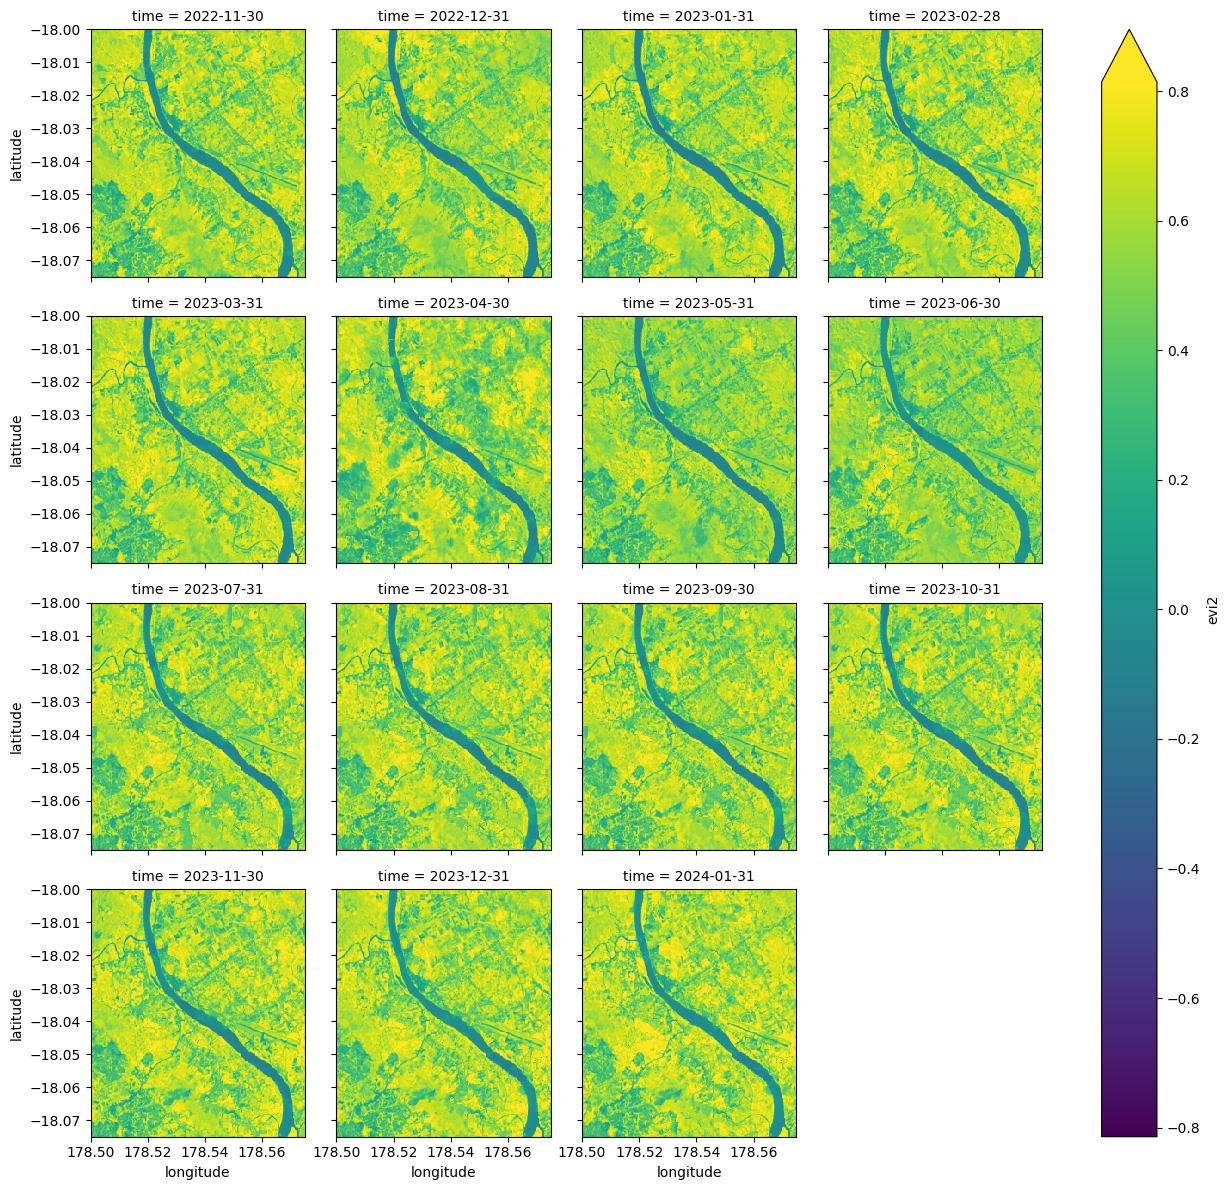

In [56]:
monthly = loaded.evi2.resample(time="1M").median()

# Todo: see if this can be done with more fancy interpolation
monthly_filled = monthly.bfill("time").ffill("time")

monthly_filled.plot.imshow(col="time", col_wrap=4, robust=True, cmap="viridis")

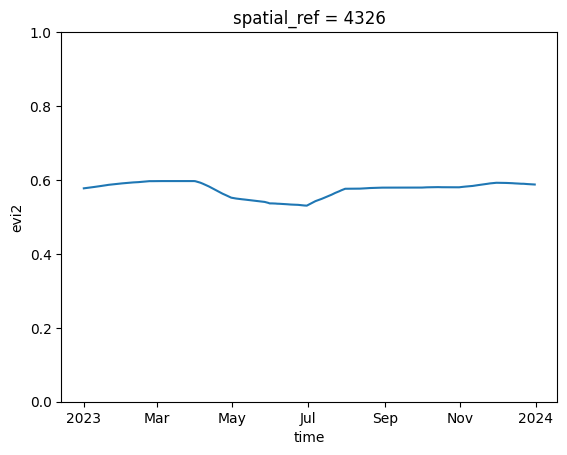

In [58]:
daily = monthly_filled.resample(time="1D")
daily_filled = daily.interpolate("linear").sel(time=slice("2023-01-01", "2023-12-31"))

# Create a spatial median
daily_summary = daily_filled.median(["longitude", "latitude"])

# Plot the time series
daily_summary.plot(ylim=(0, 1))



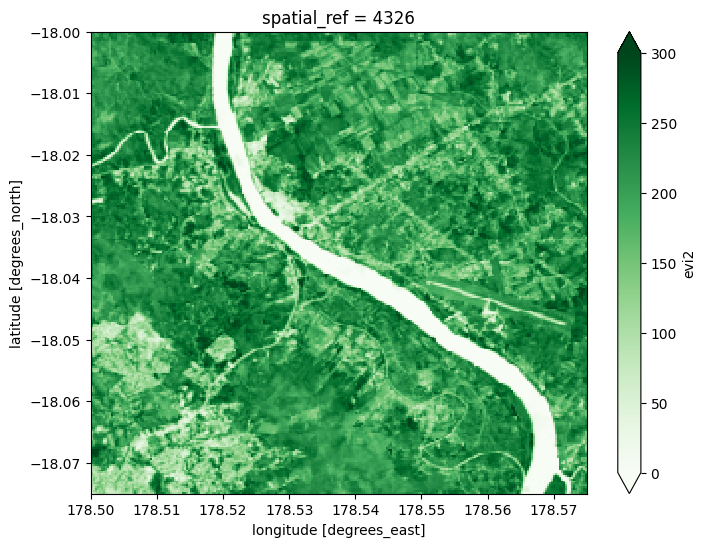

In [60]:
integral = daily_filled.integrate("time", datetime_unit="D")

integral.plot(robust=True, cmap="Greens", size=6, vmin=0, vmax=300)